<a href="https://colab.research.google.com/github/SoumikNandi01/Simulation-of-SuperFluid-Dark-Matter-using-PyAutoLens/blob/master/Conv_Autoencoder_Cosmological_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing necessary modules

In [0]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

## Mounting google Drive

In [165]:
from google.colab import drive
drive.mount(r'/content/drive/', force_remount = True)

Mounted at /content/drive/


In [0]:
#!unzip -uq "/content/drive/My Drive/CERN_NEW.zip" -d "/content/drive/My Drive/CERN_datas/CERN_new_images"

## Loading and Preprocessing data (trained on 1000 Strong Lens Images)

In [0]:
img_transform = transforms.Compose([
    transforms.Resize((143,143)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [0]:
def load_dataset(image_folder):
    data_path = r'/content/drive/My Drive/'+image_folder
    train_dataset = tv.datasets.ImageFolder(
        root=data_path,
        transform=img_transform
    )
    print("No of found images ", len(train_dataset))
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size = 32,
        num_workers=0,
        shuffle=True
    )
    return train_loader

In [169]:
train_loader = load_dataset('CERN_datas')
train_loader
dataiter = iter(train_loader)
image = dataiter.next()
dataiter

No of found images  1004


## Visualising the data

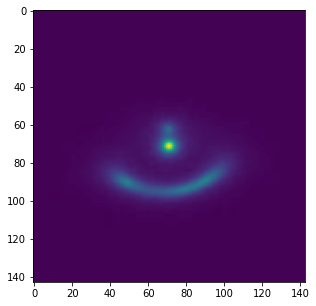

In [170]:
item = iter(train_loader)
dataiter = item.next()
images = dataiter[0].numpy()
img = np.squeeze(images[0])
img = np.squeeze(img[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img)

In [171]:
dataiter[0].shape

torch.Size([32, 3, 143, 143])

### Modelling the Convolutional Autoencoder

In [0]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 256, 3, stride = 2, padding = 0),  # b, 16, 10, 10
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 256, 3, stride = 2, padding = 0),  # b, 8, 3, 3
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 512, 3, stride = 2, padding = 0),  # b, 8, 3, 3
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 1024, 3, stride = 2, padding = 0),  # b, 8, 3, 3
            nn.BatchNorm2d(1024),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 3, stride=2, padding = 0),  # b, 16, 5, 5
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding = 0),  # b, 8, 15, 15
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 256, 3, stride=2, padding = 0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 3, 3, stride = 2, padding = 0),  # b, 8, 15, 15
            nn.BatchNorm2d(3), # b, 1, 28, 28
            nn.Tanh()
        )
    def forward(self, x):
        x = self.encoder(x)
        enc = x
        x = self.decoder(x)
        return x, enc



In [0]:
model = ConvAutoencoder().cuda()
try:
  model = torch.load(r'/content/drive/My Drive/Model.pickle')
  model.eval()
except:
  pass

## The Architecture

In [174]:
print(model)

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2))
    (10): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose

In [0]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 10

## Training

In [199]:
for epoch in range(1, n_epochs+1):
  train_loss = 0.0
  for data in train_loader:
      images = data[0]
      outputs,inputs = model(images.cuda())
      #print(inputs.shape, outputs.shape)
      loss = criterion(outputs, images.cuda())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss += loss.item()*images.size(0)

  train_loss = train_loss/len(train_loader)
  training_loss.append(train_loss)

  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))


Epoch: 1 	Training Loss: 0.047264
Epoch: 2 	Training Loss: 0.047269
Epoch: 3 	Training Loss: 0.046670
Epoch: 4 	Training Loss: 0.046837
Epoch: 5 	Training Loss: 0.046840
Epoch: 6 	Training Loss: 0.046836
Epoch: 7 	Training Loss: 0.047215
Epoch: 8 	Training Loss: 0.047265
Epoch: 9 	Training Loss: 0.046536
Epoch: 10 	Training Loss: 0.046843


## PLotting The Loss ( Post 135 Epochs, with 100 epochs = (lr=0.1), 35 epochs (lr=0.001) )

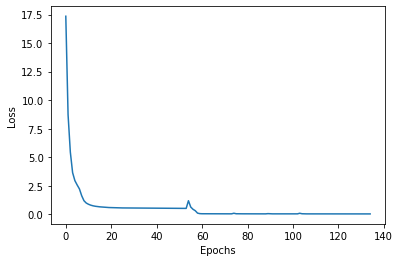

In [203]:
plt.plot(np.arange(135),training_loss[-135:])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [0]:
torch.save(model,r'/content/drive/My Drive/Model.pickle')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ConvAutoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
def plot_all(loader):
  w = 143
  h = 143
  fig = plt.figure(figsize=(8, 8))
  columns = loader.shape[0]
  rows = 1
  for i in range(1, columns*rows +1):
      img = np.random.randint(10, size=(h,w))
      fig.add_subplot(rows, columns, i).title.set_text("Vector = V"+str(i-1))
      img = loader[i-1]
      img = np.squeeze(img[0])
      plt.imshow(img)
  plt.show()

In [0]:
def generate_latent_vects(test_data_loader,flag):
  latent_vects = []
  for data in test_data_loader:
    images = data[0]
    if flag:
      plot_all(images)
    _, embeddings = model(images.cuda())
    np.squeeze(embeddings[0].cpu().detach().numpy()).reshape(-1,64)
    latent_vects.append(embeddings)
  return latent_vects


def make_embeddings(image_folder, flag):
  test_data_loader = load_dataset(image_folder)
  return generate_latent_vects(test_data_loader,flag)



def return_ready_vectors(embeddings):
  vectors = []
  for i in range(embeddings.shape[0]):
    vectors.append(embeddings[i].flatten().cpu().detach().numpy().reshape(-1,65536))
  return vectors

No of found images  5


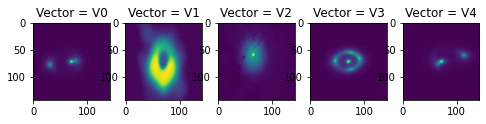

In [206]:
v = return_ready_vectors(make_embeddings("CERN_validation",True)[0])

V0 = Substructure

V1 = Image of a black hole (Anomaly)

V2 = Image of a Moon (Anomaly)

V3 = No Substructure

V4 = Substructure

In [207]:
print(cosine_similarity(v[0],v[1])) #V1 is anomaly
print(cosine_similarity(v[1],v[2])) #Both Anomaly (Undesirable Image)
print(cosine_similarity(v[0],v[3])) #Comparison of Substructure with non Substructure (Also differentiates between multiple substructures)
print(cosine_similarity(v[0],v[4])) #Contains Substructure
print(cosine_similarity(v[3],v[4])) #Comparison of Substructure with non Substructure (Also differentiates between multiple substructures)


[[0.14190018]]
[[0.39191055]]
[[0.577495]]
[[0.7588542]]
[[0.56685925]]
